# Long Homework 1

## AMPTH 207: Stochastic Methods for Data Analysis, Inference and Optimization
 
**Due Date:** Thursday, Febrary 23rd, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Premise

In supervised machine learning, a function that maps certain input data to a set of outputs is inferred from a labelled dataset called the training set, and the resulting learnt funtion is then used to make predictions on unseen new examples of the dataset (the test set).

The goal of this homework is to construct a classifier known as the single-hidden-layer Multi-Layer Perceptron (MLP), an artificial neural netwok. You are asked to train the classifier using mini-batch gradient descent, validate it, and then apply it to a test dataset to make predictions. We will use the [*MNIST* dataset](https://en.wikipedia.org/wiki/MNIST_database), which consists of 70,000 images of handwritten digits, each of which is 28x28 pixels. You can use the first 50,000 images as the training set, the next 10,000 images as the validation set, and the last 10,000 images as the test set.

You will proceed in 2 steps (each step is a problem) to build the MLP. Please use Theano to program the classifiers.

## Problem 1. Stochastic gradient descent for the logistic regresion

First, build a logistic regression classifier whose input is the array of pixel values in one image, and whose output is the most likely class of the vector. In order to familiarize yourself with the dataset, plot some of the images beforehand, and think about the pixel values as features of the input vector.

### Part A

Using the softmax formulation, write a Theano expression graph that:
* Calculates the probability of a target element belonging to class $i$ (i.e., the probability that a given image represents a digit between 0 and 9).
* Maximizes it over all classes, and computes the cost function using an L2 regularization approach
* Minimizes the resulting cost function using mini-batch gradient descent. How long does it take for your code to train with 50,000 training examples of the dataset?

*Hint: Use a batch size of 256 examples, a learning rate $\eta = 0.1$, and a regularization factor $\lambda=0.01$*.

In [1]:
import gzip
import datetime
import numpy as np
import theano
import theano.tensor as T
import six.moves.cPickle as pickle
dataset='mnist.pkl.gz'
with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

In [2]:
eta = 0.1 # Learning rate
lambdas = 0.01 # regularization factor 
x = T.dmatrix('x')
y = T.lvector('y')
w = theano.shared(np.random.randn(train_set[0].shape[1],len(np.unique(train_set[1]))),name='w',borrow=True)
b = theano.shared(value=np.zeros((len(np.unique(train_set[1])),),dtype=theano.config.floatX),name='b',borrow=True)
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambdas * (w ** 2).sum()      # The cost to minimize
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)
train = theano.function(inputs=[x,y], outputs=[prediction, loss],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')
# Train
n_epochs = 100
batch_size = 256    # size of the minibatch
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size
error_train = []   
error_valid = []
error_new, error_old, i = 1,0,0
time1=datetime.datetime.now()
while abs(error_old - error_new) > 1e-4: ## early stop
    error_old = error_new
    order = np.random.permutation(train_set[0].shape[0])
    permutex = train_set[0][order]
    permutey = train_set[1][order]
    error_valid_int = []
    for index in range(n_train_batches):
        # Now for the update we only use one mini-batch at a time
        pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                          permutey[index * batch_size: (index + 1) * batch_size])
        error_train.append(err)  # save the train error for this batch
        errores = []             
        # Now we check the performance on the validation set, every 2 batches.
        if (index%2 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            # We get the validation error as the average over batches
            this_error = np.mean(errores)
            error_valid.append(this_error)
            error_valid_int.append(this_error)            
    error_new = np.mean(error_valid_int)
    i=i+1
    if(i==n_epochs):break ## compulsory stop
time2=datetime.datetime.now()
print(i,error_old,error_new,time2-time1)

14 0.441301665703 0.441334908689 0:00:47.881992


### Part B

* Evaluate the validation loss function periodically as you train the classifier and plot it as a function of the epoch. Plot this loss function for several values of the regularization factor.
* When should you stop the training for different values of $\lambda$? Give an approximate answer supported by using the plots.
* Select what you consider the best regularization factor and predict the classes of the test set. Compare with the given labels. What is the test error that you obtain?

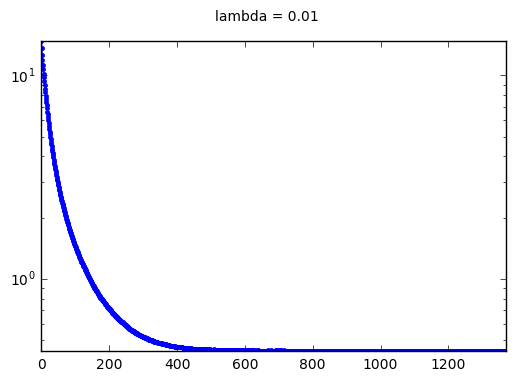

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(len(error_valid)),np.array(error_valid),marker='.')
plt.suptitle('lambda = 0.01')
plt.axis('tight')
plt.yscale('log')

In [4]:
eta = 0.1 # Learning rate
lambdas = 0.005 # regularization factor 
x = T.dmatrix('x')
y = T.lvector('y')
w = theano.shared(np.random.randn(train_set[0].shape[1],len(np.unique(train_set[1]))),name='w',borrow=True)
b = theano.shared(value=np.zeros((len(np.unique(train_set[1])),),dtype=theano.config.floatX),name='b',borrow=True)
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambdas * (w ** 2).sum()      # The cost to minimize
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)
train = theano.function(inputs=[x,y], outputs=[prediction, loss],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')
# Train
n_epochs = 100
batch_size = 256    # size of the minibatch
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size
error_train = []   
error_valid = []
error_new, error_old, i = 1,0,0
time1=datetime.datetime.now()
while abs(error_old - error_new) > 1e-4: ## early stop
    error_old = error_new
    order = np.random.permutation(train_set[0].shape[0])
    permutex = train_set[0][order]
    permutey = train_set[1][order]
    error_valid_int = []
    for index in range(n_train_batches):
        # Now for the update we only use one mini-batch at a time
        pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                          permutey[index * batch_size: (index + 1) * batch_size])
        error_train.append(err)  # save the train error for this batch
        errores = []             
        # Now we check the performance on the validation set, every 2 batches.
        if (index%2 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            # We get the validation error as the average over batches
            this_error = np.mean(errores)
            error_valid.append(this_error)
            error_valid_int.append(this_error)           
    error_new = np.mean(error_valid_int)
    i=i+1
    if(i==n_epochs):break ## compulsory stop
time2=datetime.datetime.now()
print(i,error_old,error_new,time2-time1)

15 0.3768324747 0.376804462154 0:00:50.470418


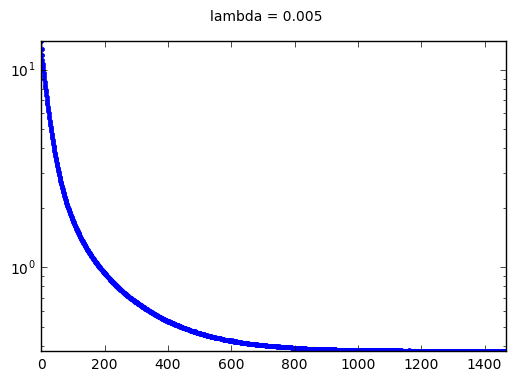

In [5]:
plt.plot(np.arange(len(error_valid)),np.array(error_valid),marker='.')
plt.suptitle('lambda = 0.005')
plt.axis('tight')
plt.yscale('log')

In [6]:
eta = 0.1 # Learning rate
lambdas = 0.05 # regularization factor 
x = T.dmatrix('x')
y = T.lvector('y')
w = theano.shared(np.random.randn(train_set[0].shape[1],len(np.unique(train_set[1]))),name='w',borrow=True)
b = theano.shared(value=np.zeros((len(np.unique(train_set[1])),),dtype=theano.config.floatX),name='b',borrow=True)
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambdas * (w ** 2).sum()      # The cost to minimize
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)
train = theano.function(inputs=[x,y], outputs=[prediction, loss],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')
# Train
n_epochs = 100
batch_size = 256    # size of the minibatch
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size
error_train = []   
error_valid = []
error_new, error_old, i = 1,0,0
time1=datetime.datetime.now()
while abs(error_old - error_new) > 1e-4: ## early stop
    error_old = error_new
    order = np.random.permutation(train_set[0].shape[0])
    permutex = train_set[0][order]
    permutey = train_set[1][order]
    error_valid_int = []
    for index in range(n_train_batches):
        # Now for the update we only use one mini-batch at a time
        pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                          permutey[index * batch_size: (index + 1) * batch_size])
        error_train.append(err)  # save the train error for this batch
        errores = []             
        # Now we check the performance on the validation set, every 2 batches.
        if (index%2 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            # We get the validation error as the average over batches
            this_error = np.mean(errores)
            error_valid.append(this_error)
            error_valid_int.append(this_error)           
    error_new = np.mean(error_valid_int)
    i=i+1
    if(i==n_epochs):break ## compulsory stop
time2=datetime.datetime.now()
print(i,error_old,error_new,time2-time1)

11 0.723924233302 0.723847872054 0:00:36.418587


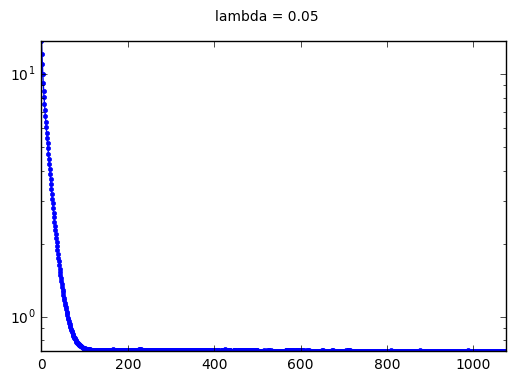

In [7]:
plt.plot(np.arange(len(error_valid)),np.array(error_valid),marker='.')
plt.suptitle('lambda = 0.05')
plt.axis('tight')
plt.yscale('log')

In [8]:
eta = 0.1 # Learning rate
lambdas = 0.001 # regularization factor 
x = T.dmatrix('x')
y = T.lvector('y')
w = theano.shared(np.random.randn(train_set[0].shape[1],len(np.unique(train_set[1]))),name='w',borrow=True)
b = theano.shared(value=np.zeros((len(np.unique(train_set[1])),),dtype=theano.config.floatX),name='b',borrow=True)
p_y_given_x = T.nnet.softmax(T.dot(x, w) + b)   # Probability that target belongs to class i
prediction = T.argmax(p_y_given_x, axis=1)      # The prediction of the model (class whose probability is maximal)
loss = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])  # Loss function
cost = loss.mean() + lambdas * (w ** 2).sum()      # The cost to minimize
gw = T.grad(cost=cost, wrt=w)
gb = T.grad(cost=cost, wrt=b)
train = theano.function(inputs=[x,y], outputs=[prediction, loss],
          updates=((w, w - eta * gw), (b, b - eta * gb)),name='train')
validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')
# Train
n_epochs = 100
batch_size = 256    # size of the minibatch
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size
error_train = []   
error_valid = []
error_new, error_old, i = 1,0,0
time1=datetime.datetime.now()
while abs(error_old - error_new) > 1e-4: ## early stop
    error_old = error_new
    order = np.random.permutation(train_set[0].shape[0])
    permutex = train_set[0][order]
    permutey = train_set[1][order]
    error_valid_int = []
    for index in range(n_train_batches):
        # Now for the update we only use one mini-batch at a time
        pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                          permutey[index * batch_size: (index + 1) * batch_size])
        error_train.append(err)  # save the train error for this batch
        errores = []             
        # Now we check the performance on the validation set, every 2 batches.
        if (index%2 == 0):
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
            # We get the validation error as the average over batches
            this_error = np.mean(errores)
            error_valid.append(this_error)
            error_valid_int.append(this_error)           
    error_new = np.mean(error_valid_int)
    i=i+1
    if(i==n_epochs):break ## compulsory stop
time2=datetime.datetime.now()
print(i,error_old,error_new,time2-time1)

47 0.297474047707 0.29742780134 0:02:36.084479


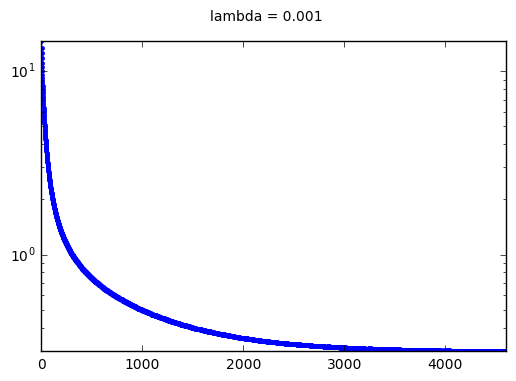

In [9]:
plt.plot(np.arange(len(error_valid)),np.array(error_valid),marker='.')
plt.suptitle('lambda = 0.001')
plt.axis('tight')
plt.yscale('log')

I stop the training process when the difference in average validate error across batches is smaller than 1e-4. For example, in the case of $\lambda=0.01$, I stop training after 13 rounds of mini-batch gradient descent, within each round there are [50000/256] updates for the parameter $w$ and $b$. Below is a summary table of results under different choices of $\lambda$.\\

In [10]:
from IPython.display import HTML, display
temp = [['Lambda','Average Loss','Rounds of updates','Time Needed'],
         [0.05,0.7239,11,'00:36'],
         [0.01,0.4413,14,'00:48'],
         [0.005,0.3768,15,'00:50'],
         [0.001,0.2975,47,'02:36'],
         ]

display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in temp)
        )
 ))

Lambda,Average Loss,Rounds of updates,Time Needed
0.05,0.7239,11,00:36
0.01,0.4413,14,00:48
0.005,0.3768,15,00:50
0.001,0.2975,47,02:36


In [11]:
aa = T.dvector('aa')
bb = T.dvector('bb')
cc = T.mean(T.neq(aa, bb))
f_err = theano.function([aa, bb], cc)
print('Test error = ',100.*f_err(test_set[1],predict(test_set[0])))

Test error =  8.28


I would like to choose $\lambda=0.001$, it reaches the minimun average loss and consumes a reasonable amount of time, the test error is 8.28%.

## Problem 2. The Multilayer Perceptron (with one hidden layer)
The multilayer perceptron can be understood as a logistic regression classifier in which the input is first transformed using a learnt non-linear transformation. The non-linear transformation is usually chosen to be either the logistic function or the $\tanh$ function, and its purpose is to project the data into a space where it becomes linealry separable The output of this so-called hidden layer is then passed to the logistic regression graph that we have constructed in the first problem. In matrix notation:

$$G(b^{(2)}+W^{(2)}(s(b^{(1)}W^{(1)}x)))$$

with bias vectors $b^{(1)}$, $b^{(2)}$; weight matrices $W^{(1)}$, $W^{(2)}$ and activation functions $G$ and $s$. Here is a diagram:

![](http://deeplearning.net/tutorial/_images/mlp.png){:height=300 width=300}

### Part A

Using a similar architecture as in the first part and the same MNIST dataset, built a Theano graph for the multilayer perceptron, using the $\tanh$ function as the non-linearity. Use $\eta = 0.1$ and $\lambda = 0.001$. Experiment with the batch size (use 20, 50, and 100 examples) and the number of units in your hidden layer (use 50, 100, and 200 units). For what combination of these parameters do you obtain the smallest value of the validation loss function after 50 epochs?

### Part B

Stop the trainning at a convenient validation loss and use the trained classifier to predict for the test set. How much better is your test error as compared to the logistic regression classifier?

*Hint 1:* The initialization of the weights matrix for the hidden layer must assure that the units (neurons) of the perceptron operate in a regime where information gets propagated. For the $\tanh$ function, it is advisable to initialize with the interval $[-\sqrt{\frac{6}{fan_{in}+fan_{out}}},\sqrt{\frac{6}{fan_{in}+fan_{out}}}]$, where $fan_{in}$ is the number of units in the $(i-1)$-th layer, and $fan_{out}$ is the number of units in the i-th layer.

*Hint 2:* You should feel free to get inspiration from [these tutorials](http://deeplearning.net/tutorial/mlp.html). However, we expect you to write your own code, inspired by the architecture shown in the lab.

In [2]:
for batch_size in [20,50,100]:
    for n_hidden in [50,100,200]:
        eta = 0.1 # Learning rate
        lambdas = 0.001 # regularization factor 
        x = T.dmatrix('x')
        y = T.lvector('y')
        n_in = train_set[0].shape[1]
        n_out = len(np.unique(train_set[1]))
        w1 = theano.shared(np.random.uniform(low=-np.sqrt(6. / (n_in + n_hidden)),
                    high=np.sqrt(6. / (n_in + n_hidden)),size=(n_in, n_hidden)),name='w',borrow=True)
        w2 = theano.shared(np.random.randn(n_hidden,n_out),name='w',borrow=True)
        b1 = theano.shared(value=np.zeros(n_hidden, dtype=theano.config.floatX),name='b',borrow=True)
        b2 = theano.shared(value=np.zeros(n_out, dtype=theano.config.floatX),name='b',borrow=True)

        h = T.tanh(T.dot(x, w1) + b1)
        p_y_given_h = T.nnet.softmax(T.dot(h, w2) + b2)  
        prediction = T.argmax(p_y_given_h, axis=1)      
        loss = -T.mean(T.log(p_y_given_h)[T.arange(y.shape[0]), y])  
        cost = loss.mean() + lambdas * ((w1**2).sum() + (w2**2).sum())  
        gw1 = T.grad(cost=cost, wrt=w1)
        gw2 = T.grad(cost=cost, wrt=w2)
        gb1 = T.grad(cost=cost, wrt=b1)
        gb2 = T.grad(cost=cost, wrt=b2)

        train = theano.function(inputs=[x,y], outputs=[prediction, loss],
                updates=((w1, w1 - eta * gw1), (w2, w2 - eta * gw2),
                (b1, b1 - eta * gb1), (b2, b2 - eta * gb2)),name='train')
        validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
        test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
        predict = theano.function(inputs=[x], outputs=prediction, name='predict')
        # Train
        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size
        error_train = []   
        error_valid = []
        error_new, error_old, i = 1,0,0
        i=0
        time1=datetime.datetime.now()
        while i<50: 
            error_old = error_new
            order = np.random.permutation(train_set[0].shape[0])
            permutex = train_set[0][order]
            permutey = train_set[1][order]
            error_valid_int = []
            for index in range(n_train_batches):
                pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                          permutey[index * batch_size: (index + 1) * batch_size])
                error_train.append(err)  # save the train error for this batch             
                if (index%2 == 0):
                    errores = []
                    for j in range(n_valid_batches):
                        pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                              valid_set[1][j * batch_size: (j + 1) * batch_size])
                        errores.append(err_val)
                this_error = np.mean(errores)
                error_valid.append(this_error)
                error_valid_int.append(this_error)            
            error_new = np.mean(error_valid_int)
            i=i+1
        time2=datetime.datetime.now()
        print('batch_size=',batch_size,'n_hidden=',n_hidden,'error=',error_new,'time=',time2-time1)

batch_size= 20 n_hidden= 50 error= 0.136652355855 time= 1:09:04.798325
batch_size= 20 n_hidden= 100 error= 0.128706196052 time= 1:28:31.390745
batch_size= 20 n_hidden= 200 error= 0.128080647713 time= 1:59:14.903516
batch_size= 50 n_hidden= 50 error= 0.132305761701 time= 0:19:16.868359
batch_size= 50 n_hidden= 100 error= 0.124063054504 time= 0:27:26.865372
batch_size= 50 n_hidden= 200 error= 0.12441433617 time= 0:39:48.138210
batch_size= 100 n_hidden= 50 error= 0.136850608483 time= 0:08:16.656609
batch_size= 100 n_hidden= 100 error= 0.12608560783 time= 0:12:23.679375
batch_size= 100 n_hidden= 200 error= 0.125196422871 time= 0:20:42.835217


In [29]:
batch_size = 100
n_hidden = 200
eta = 0.1 # Learning rate
lambdas = 0.001 # regularization factor 
x = T.dmatrix('x')
y = T.lvector('y')
n_in = train_set[0].shape[1]
n_out = len(np.unique(train_set[1]))
w1 = theano.shared(np.random.uniform(low=-np.sqrt(6. / (n_in + n_hidden)),
     high=np.sqrt(6. / (n_in + n_hidden)),size=(n_in, n_hidden)),name='w',borrow=True)
w2 = theano.shared(np.random.randn(n_hidden,n_out),name='w',borrow=True)
b1 = theano.shared(value=np.zeros(n_hidden, dtype=theano.config.floatX),name='b',borrow=True)
b2 = theano.shared(value=np.zeros(n_out, dtype=theano.config.floatX),name='b',borrow=True)

h = T.tanh(T.dot(x, w1) + b1)
p_y_given_h = T.nnet.softmax(T.dot(h, w2) + b2)  
prediction = T.argmax(p_y_given_h, axis=1)      
loss = -T.mean(T.log(p_y_given_h)[T.arange(y.shape[0]), y])  
cost = loss.mean() + lambdas * ((w1**2).sum() + (w2**2).sum())  
gw1 = T.grad(cost=cost, wrt=w1)
gw2 = T.grad(cost=cost, wrt=w2)
gb1 = T.grad(cost=cost, wrt=b1)
gb2 = T.grad(cost=cost, wrt=b2)
train = theano.function(inputs=[x,y], outputs=[prediction, loss],
        updates=((w1, w1 - eta * gw1), (w2, w2 - eta * gw2),
        (b1, b1 - eta * gb1), (b2, b2 - eta * gb2)),name='train')
validate = theano.function(inputs=[x,y],outputs=[prediction, loss],name='validate')
test = theano.function(inputs=[x,y],outputs=[prediction, loss],name='test')
predict = theano.function(inputs=[x], outputs=prediction, name='predict')
# Train
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size
error_train = []   
error_valid = []
error_new, error_old, i = 1,0,0
i=0
time1=datetime.datetime.now()
while i<50: 
    error_old = error_new
    order = np.random.permutation(train_set[0].shape[0])
    permutex = train_set[0][order]
    permutey = train_set[1][order]
    error_valid_int = []
    for index in range(n_train_batches):
        pred, err = train(permutex[index * batch_size: (index + 1) * batch_size], \
                    permutey[index * batch_size: (index + 1) * batch_size])
        error_train.append(err)  # save the train error for this batch             
        if (index%2 == 0):
            errores = []
            for j in range(n_valid_batches):
                pred_val, err_val = validate(valid_set[0][j * batch_size: (j + 1) * batch_size], \
                        valid_set[1][j * batch_size: (j + 1) * batch_size])
                errores.append(err_val)
        this_error = np.mean(errores)
        error_valid.append(this_error)
        error_valid_int.append(this_error)            
    error_new = np.mean(error_valid_int)
    i=i+1
time2=datetime.datetime.now()
print('batch_size=',batch_size,'n_hidden=',n_hidden,'error=',error_new,'time=',time2-time1)

batch_size= 100 n_hidden= 200 error= 0.125550669009 time= 0:25:55.166655


In [30]:
print('Test error = ',100.*f_err(test_set[1],predict(test_set[0])))

Test error =  3.29


The Test error reduces from 8.28% to 3.29%